# Digit Recognizer

This was a kaggle competition. Here is the data: https://www.kaggle.com/c/digit-recognizer.

with Mkrtich Ohanyan.

In [20]:
import os 

#Find train and test data.
training=os.path.abspath('train.csv')
testing=os.path.abspath('test.csv')

In [21]:
import pandas as pd
import numpy as np


#Read the train and test data.
train=pd.read_csv(training)
test=pd.read_csv(testing)

In [22]:
#In X, we have columns which are the individual pixels in the handwritten digits. 
#Since the digits are in black and white (and gray), we have values between 0 and 1. 
#In y, we have the number represented in the handwritten digit (0-9).


X=train.drop('label',axis=1).values.astype('float32')
y=train['label'].values.astype('int32')

In [23]:
import tensorflow as tf
from tensorflow import keras


#Change y data type to categorical
from keras.utils import np_utils
y = np_utils.to_categorical(y) 

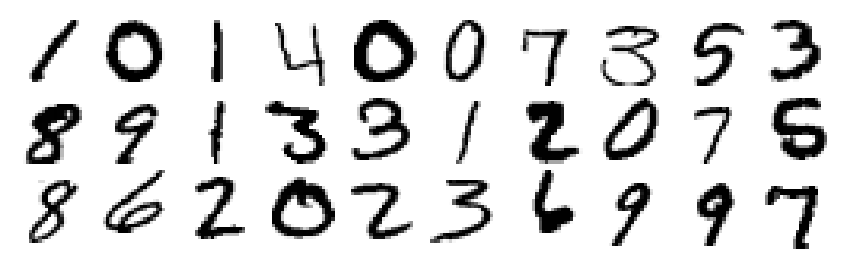

In [24]:
#Plot some handwritten digits.

import matplotlib.pyplot as plt
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#Add rotations, zoom, shift, rescale to the training/testing data.
datagen_train = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        rescale=1/255.)

datagen_test = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        rescale=1/255.)

In [26]:
#Train, test, split.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test=train_test_split(X,y,random_state=0)


#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

Next, we will create our model.

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten

model = keras.Sequential([
    layers.InputLayer(input_shape=(28,28,1)),

    layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32,kernel_size=5,strides=2,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Conv2D(64, kernel_size = 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size = 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Conv2D(128, kernel_size = 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax'),
])
    

Compile the model, fit our rotations/zooms/shifts to the training data, and then fit our X_train, y_train, to our model.

In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],)

datagen_train.fit(X_train)
model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = 32),
                    validation_data = (X_test, y_test), steps_per_epoch = len(X_train) // 32,
                    epochs = 10)

# early_stopping = keras.callbacks.EarlyStopping(
#     patience=5,
#     min_delta=0.01,
#     restore_best_weights=True,
# )

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
#    callbacks=[early_stopping],
    batch_size=64,
    epochs=150,
)

Epoch 1/10
984/984 [==============================] - 149s 150ms/step - loss: 0.0483 - accuracy: 0.9852 - val_loss: 10.6657 - val_accuracy: 0.8901
Epoch 2/10
984/984 [==============================] - 203s 207ms/step - loss: 0.0460 - accuracy: 0.9855 - val_loss: 10.3024 - val_accuracy: 0.8795
Epoch 3/10
984/984 [==============================] - 164s 167ms/step - loss: 0.0433 - accuracy: 0.9868 - val_loss: 20.4381 - val_accuracy: 0.8630
Epoch 4/10
984/984 [==============================] - 158s 161ms/step - loss: 0.0390 - accuracy: 0.9887 - val_loss: 8.2189 - val_accuracy: 0.9512
Epoch 5/10
984/984 [==============================] - 144s 146ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 12.3559 - val_accuracy: 0.8988
Epoch 6/10
984/984 [==============================] - 131s 133ms/step - loss: 0.0387 - accuracy: 0.9887 - val_loss: 14.2461 - val_accuracy: 0.8894
Epoch 7/10
984/984 [==============================] - 137s 139ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 18.

KeyboardInterrupt: 

Next, we look at how our loss and accuracy of the training data compare to the loss and accuracy of our test data.

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title="Loss: Training data vs validation data")
history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy: Training vs validation data")

In [ ]:
test= test.values.astype('float32')
test = test.reshape(test.shape[0], 28, 28,1)
label=model.predict_classes(test)
label

In [ ]:
my_submission = pd.DataFrame({'ImageId': list(range(1,len(label)+1)), 'Label': label})
my_submission.to_csv('submission.csv', index=False)